In [106]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from torch.ao.nn.quantized import Dropout

In [107]:
# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [108]:
df = pd.concat([train, test], axis=0, ignore_index=True)
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
(1309, 12)


<Axes: >

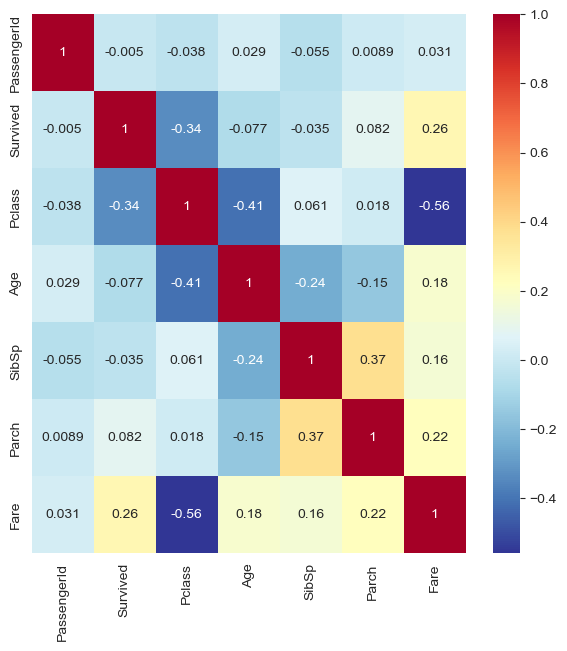

In [109]:
# df 상관관계보기: https://m.blog.naver.com/kiddwannabe/221763497317
# 상관관계 봐보자
plt.figure(figsize=(7,7))
# 그냥하면 object 타입땜에 오류남 -> 수치형 데이터만 상관관계
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), cmap='RdYlBu_r', annot=True)

In [110]:
print(train.columns, train.shape)
print(test.columns, test.shape)
print(train.describe())
print(test.describe())
# target -> Survived

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') (891, 12)
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') (418, 11)
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.

In [111]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [112]:
# passengerID 처리
df = df.set_index('PassengerId')

In [113]:
# Pclass 처리
df["Pclass"] = df["Pclass"].astype('category')

In [114]:
# Name 이름 처리 
# -> Name의 Title에는 성병, 사회지위, 직업, 신분이 포함됨

# Name에서 Title 추출
df['Title'] = df["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df["Title"] = df["Title"].astype('category')

In [115]:
# Sex 성별 처리
df['Sex'] = df['Sex'].map({'female': 0, 'male': 1}).astype('category')

In [116]:
# # Pclass + 성별 그룹 생성
df['PclassSex'] = df['Pclass'].astype(str) + df['Sex'].astype(str)
df['PclassSex'] = df['PclassSex'].astype('category')
# print(df.head())
# df[['PclassSex', 'Survived']].groupby(['PclassSex'], as_index=False,observed=True).mean().sort_values(by='Survived', ascending=False)

In [117]:
# Age 나이 처리

# Age 나이 데이터의 결측치를 Title 별 나이의 median 값으로 처리
df["Age"] = df.groupby("Title", observed=True)["Age"].transform(lambda x: x.fillna(x.median()))

# # 이후 처리되지 않은 결측치는 Pclass, 성별 별 나이의 median 값으로 처리
df['Age'] = df.groupby('PclassSex', observed=True)['Age'].transform(lambda x: x.fillna(x.median()))
df['Age'] = df['Age'].astype(int)

In [118]:
# age 범위 cut
print(pd.cut(df['Age'], 4).value_counts())

Age
(20.0, 40.0]     827
(-0.08, 20.0]    257
(40.0, 60.0]     193
(60.0, 80.0]      32
Name: count, dtype: int64


In [119]:
# Age 나이를 가지고 연령대 column 생성 'AgeGroup'
df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[-float('inf'), 16, 32, 48, 64, float('inf')], 
                        labels=[0, 1, 2, 3, 4]).astype('category')
# df[['AgeGroup', 'Survived']].groupby(['AgeGroup'], as_index=False,observed=True).mean().sort_values(by='Survived', ascending=False)

In [120]:
# 나이그룹 + 성별 column 'AgeSex'
df['AgeSex'] = df['AgeGroup'].astype(str) + df['Sex'].astype(str)
df['AgeSex'] = df['AgeGroup'].astype('category')
# df[['AgeSex', 'Survived']].groupby(['AgeSex'],observed=True).mean().sort_values(by='Survived', ascending=False)
# 기존 AgeGroup 이랑 특징 차이가 안남 생존률이 거의동일 사용X

In [121]:
# SibSp Parch 데이터 처리
# Family 수 column 생성
df["FamilyCount"] = df["SibSp"] + df["Parch"] + 1
family_min = df['FamilyCount'].min()
family_max = df['FamilyCount'].max()

print(family_min, family_max)

# FamilyCount를 가지고 가족수별 그룹 column 생성 'FamilyGroup'
df['FamilyGroup'] = pd.cut(df['FamilyCount'], 
                           bins=[0, 1, 4, 6, float('inf')],  
                           labels=[0,1,2,3]).astype('category')
# df[['FamilyGroup', 'Survived']].groupby(['FamilyGroup'], as_index=False,observed=True).mean().sort_values(by='Survived', ascending=False)

1 11


In [122]:
# Fare 요금 데이터 처리

# Fare -> pclass 별 평균값으로 결축치 처리
df['Fare'] = df['Fare'].fillna(df.groupby('Pclass', observed=True)['Fare'].transform('mean'))
# 요금 범주화
df['FareGroup'] = pd.qcut(df['Fare'], 5, labels=[1, 2, 3, 4, 5]).astype('category')

In [123]:
# Embarked 데이터 처리
# 가장 많은 데이터(df['Embarked'].mode()[0])로 채우기
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype('category')
# df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False,observed=True).mean().sort_values(by='Survived', ascending=False)

In [125]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Title', 'PclassSex', 'AgeGroup', 'AgeSex',
       'FamilyCount', 'FamilyGroup', 'FareGroup'],
      dtype='object')

In [126]:
df = df.drop(['Name','Ticket', 'Cabin'], axis=1)
print(df.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title', 'PclassSex', 'AgeGroup', 'AgeSex', 'FamilyCount',
       'FamilyGroup', 'FareGroup'],
      dtype='object')


In [127]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    float64 
 1   Pclass       1309 non-null   category
 2   Sex          1309 non-null   category
 3   Age          1309 non-null   int32   
 4   SibSp        1309 non-null   int64   
 5   Parch        1309 non-null   int64   
 6   Fare         1309 non-null   float64 
 7   Embarked     1309 non-null   category
 8   Title        1309 non-null   category
 9   PclassSex    1309 non-null   category
 10  AgeGroup     1309 non-null   category
 11  AgeSex       1309 non-null   category
 12  FamilyCount  1309 non-null   int64   
 13  FamilyGroup  1309 non-null   category
 14  FareGroup    1309 non-null   category
dtypes: category(9), float64(2), int32(1), int64(3)
memory usage: 79.6 KB


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,PclassSex,AgeGroup,AgeSex,FamilyCount,FamilyGroup,FareGroup
PassengerId,,,,,,,,,,,,,,,
1,0.0,3,1,22,1,0,7.2500,0,Mr,31,1,1,2,1,1
2,1.0,1,0,38,1,0,71.2833,1,Mrs,10,2,2,2,1,5
3,1.0,3,0,26,0,0,7.9250,0,Miss,30,1,1,1,0,2
4,1.0,1,0,35,1,0,53.1000,0,Mrs,10,2,2,2,1,5
5,0.0,3,1,35,0,0,8.0500,0,Mr,31,2,2,1,0,2


In [128]:
from sklearn.preprocessing import MinMaxScaler
#  ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'AgeGroup', 'FamilyGroup', 'FareGroup']
# MinMaxScaler
scaler = MinMaxScaler()
scaler_cols = ['SibSp','Parch','Age', 'Fare', 'FamilyCount']
df[scaler_cols] = scaler.fit_transform(df[scaler_cols])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    float64 
 1   Pclass       1309 non-null   category
 2   Sex          1309 non-null   category
 3   Age          1309 non-null   float64 
 4   SibSp        1309 non-null   float64 
 5   Parch        1309 non-null   float64 
 6   Fare         1309 non-null   float64 
 7   Embarked     1309 non-null   category
 8   Title        1309 non-null   category
 9   PclassSex    1309 non-null   category
 10  AgeGroup     1309 non-null   category
 11  AgeSex       1309 non-null   category
 12  FamilyCount  1309 non-null   float64 
 13  FamilyGroup  1309 non-null   category
 14  FareGroup    1309 non-null   category
dtypes: category(9), float64(6)
memory usage: 84.7 KB


In [129]:
dummy = pd.get_dummies(df, drop_first=True, dtype=float)
dummy.head()

,Survived,Age,SibSp,Parch,Fare,FamilyCount,Pclass_2,Pclass_3,Sex_1,Embarked_1,...,AgeSex_2,AgeSex_3,AgeSex_4,FamilyGroup_1,FamilyGroup_2,FamilyGroup_3,FareGroup_2,FareGroup_3,FareGroup_4,FareGroup_5
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.2750,0.125,0.0,0.014151,0.1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.4750,0.125,0.0,0.139136,0.1,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.3250,0.000,0.0,0.015469,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.4375,0.125,0.0,0.103644,0.1,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.4375,0.000,0.0,0.015713,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [130]:
print(train.shape[0])
train_dataset = dummy[:train.shape[0]]
test_dataset = dummy[train.shape[0]:]
test_dataset = test_dataset.drop("Survived", axis=1)
print(train_dataset.shape, test_dataset.shape)

X = train_dataset.drop("Survived", axis=1)
y = pd.get_dummies(train_dataset["Survived"]).astype(int).to_numpy()

891
(891, 35) (418, 34)


In [131]:
print(X.shape, y.shape, test_dataset.shape)
# print(X.dtypes, type(y))

(891, 34) (891, 2) (418, 34)


In [132]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler,ReduceLROnPlateau

In [133]:
class TitanicModel(Model):
    def __init__(self, layers_dims, activation='relu', dropout_rate=0.5, l2_beta=0.1, **kwargs):
        super(TitanicModel, self).__init__(**kwargs)
        self.layers_list = []
        prev_units = layers_dims[0]

        for units in layers_dims[1:-1]:
            self.layers_list.append(Dense(units, activation=activation, 
                                                 kernel_regularizer=regularizers.l2(l2_beta)))
            self.layers_list.append(BatchNormalization())
            self.layers_list.append(Dropout(dropout_rate))
        
        self.output_layer = Dense(layers_dims[-1], activation='softmax')  # Multi-class classification

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.layers_list:
            x = layer(x, training=training)
        
        return self.output_layer(x)

In [134]:
early_stopping = EarlyStopping(patience=10, monitor='val_loss',restore_best_weights=True)

os.makedirs('checkpoints', exist_ok=True)
checkpoint = ModelCheckpoint('checkpoints/checkpoint_{epoch}',ave_best_only=False,save_format='tf')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # 검증 손실을 모니터링
    factor=0.5,                # 학습률을 50%로 감소
    patience=3,                # 3 에포크 동안 개선되지 않으면 감소
    verbose=1,                 # 학습률 감소 시 출력
    min_lr=0.001              # 최소 학습률 설정
)
callbacks = [early_stopping]
callbacks2 = [early_stopping, reduce_lr]

In [218]:
epochs = 5000
learning_rate = 0.001
batch_size = 256
# 하이퍼파라미터 설정
input_layer = X.shape[1]
output_layer = 2 
layers_dims = [input_layer, 16, output_layer]

model = TitanicModel(layers_dims, dropout_rate=0.2, l2_beta=0.001)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])
# history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.3, callbacks=callbacks2)

Epoch 1/5000
3/3 [==============================] - 0s 54ms/step - loss: 0.7811 - accuracy: 0.5377 - val_loss: 0.6532 - val_accuracy: 0.6604 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 0s 16ms/step - loss: 0.7673 - accuracy: 0.5666 - val_loss: 0.6482 - val_accuracy: 0.6679 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 14ms/step - loss: 0.7443 - accuracy: 0.6051 - val_loss: 0.6434 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.7297 - accuracy: 0.6100 - val_loss: 0.6388 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 0s 17ms/step - loss: 0.7113 - accuracy: 0.6228 - val_loss: 0.6342 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 0s 13ms/step - loss: 0.7004 - accuracy: 0.6148 - val_loss: 0.6297 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 0s 12ms/step - loss: 0.6

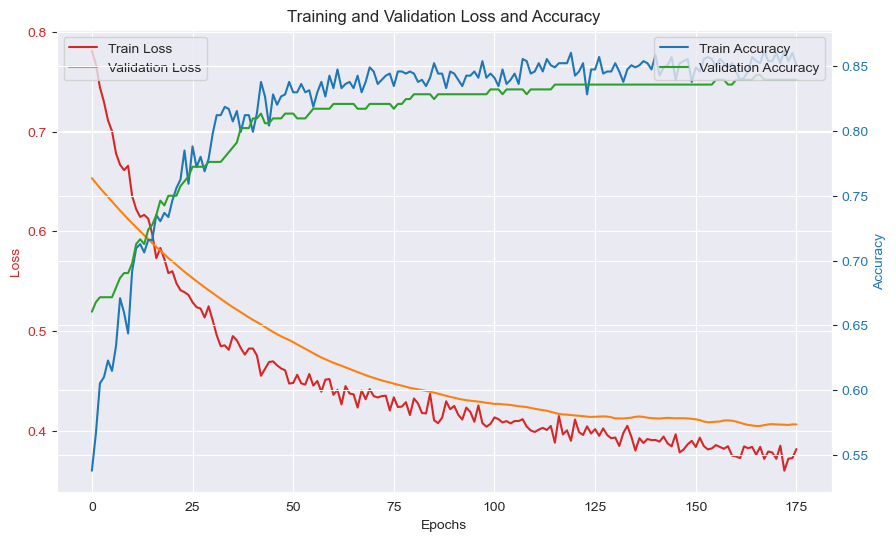

In [219]:
# 학습 및 검증 정확도와 손실을 한 그래프에 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 학습 및 검증 손실
ax1.plot(history.history['loss'], label='Train Loss', color='tab:red')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')

# 학습 및 검증 정확도 (오른쪽 y축)
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:green')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

plt.title('Training and Validation Loss and Accuracy')
plt.show()

In [221]:
model.summary()
scores = model.evaluate(X,y)
print(f"loss: {scores[0]:.3f}, acc: {scores[1] * 100:.2f}%")

Model: "titanic_model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_202 (Dense)           multiple                  560       
                                                                 
 batch_normalization_155 (Ba  multiple                 64        
 tchNormalization)                                               
                                                                 
 dropout_155 (Dropout)       multiple                  0         
                                                                 
 dense_203 (Dense)           multiple                  34        
                                                                 
Total params: 658
Trainable params: 626
Non-trainable params: 32
_________________________________________________________________
28/28 [==============================] - 0s 2ms/step - loss: 0.3860 - accuracy: 0.8519
loss: 0.386, acc: 85.19%


In [222]:
# 테스트 데이터 예측
test_pred = model.predict(test_dataset)
predictions = np.argmax(test_pred, axis=1)

14/14 [==============================] - 0s 1ms/step


In [223]:
# 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission.csv', index=False)
print('\n제출 파일이 생성되었습니다.')


제출 파일이 생성되었습니다.
